### 데이터 살펴보기 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt

from PIL import Image

In [3]:
# 마스크드 이미지
path_annotation = '/content/drive/MyDrive/dataset/data/CH07/CH07/annotations/trimaps/'

# 원본 이미지
path_image = '/content/drive/MyDrive/dataset/data/CH07/CH07/images/'

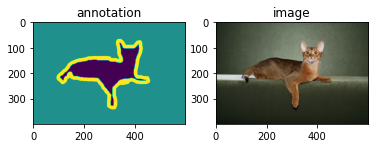

In [4]:
annotion = Image.open(path_annotation + 'Abyssinian_1.png')
plt.subplot(1, 2, 1)
plt.title('annotation')
plt.imshow(annotion)

image = Image.open(path_image + 'Abyssinian_1.jpg')
plt.subplot(1, 2, 2)
plt.title('image')
plt.imshow(image)

### 데이터세트 생성 
1. 정렬
2. 난이도 수정 

In [5]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset
from PIL import Image

In [28]:
class Pets(Dataset):
  def __init__(self, path_image, path_annotation, train=True, transforms=None, input_size=(128, 128)):
    self.images = sorted(glob.glob(path_image+'/*.jpg'))
    self.annotations = sorted(glob.glob(path_annotation+'/*.png'))

    self.X_train = self.images[:int(0.8*len(self.images))]
    self.X_test = self.images[int(0.8*len(self.images)):]
    self.y_train = self.annotations[:int(0.8*len(self.annotations))]
    self.y_test = self.annotations[int(0.8*len(self.annotations)):]

    self.train = train
    self.transforms = transforms
    self.input_size = input_size

  def __len__(self):
    if self.train:
      return len(self.X_train)
    else:
      return len(self.X_test)

  def preprocess_mask(self, mask):
    mask = mask.resize(self.input_size) # mask가 Image.open()으로 연다 => PIL 클래스 : resize
    mask = np.array(mask).astype(np.float32) # PIL => np.array
    mask[mask != 2.0] = 1.0
    mask[mask == 2.0] = 0.0
    mask = torch.tensor(mask)

  def __getitem__(self, idx):
    if self.train:
      X_train = Image.open(self.X_train[idx])
      X_train = self.transforms(X_train)
      y_train = Image.open(self.y_train[idx])
      y_train = self.transforms(y_train)

      return X_train, y_train

    else:
      X_test = Image.open(self.X_test[idx])
      X_test = self.transforms(X_test)
      y_test = Image.open(self.y_test[idx])
      y_test = self.transforms(y_test)

      return X_test, y_test

### 모델 정의 

In [29]:
import torch.nn as nn

In [99]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    # 인코더층
    # 기본 블록
    self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    # 마지막 기본 블록 - 풀링X
    self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
    self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

    # 디코더층
    # 기본 블록
    self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
    self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # 인코더 출력과 업샘플링 결과를 합치기 때문
    self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

    self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
    self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

    self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
    self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

    self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
    self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

    # 활성화함수
    self.relu = nn.ReLU()

  # 순전파
  # 인코더 순전파
  def forward(self, x):
    x = self.enc1_1(x)
    x = self.relu(x)
    e1 = self.enc1_2(x)
    e1 = self.relu(e1)
    x = self.pool1(e1)

    x = self.enc2_1(x)
    x = self.relu(x)
    e2 = self.enc2_2(x)
    e2 = self.relu(e2)
    x = self.pool2(e2)

    x = self.enc3_1(x)
    x = self.relu(x)
    e3 = self.enc3_2(x)
    e3 = self.relu(e3)
    x = self.pool3(e3)

    x = self.enc4_1(x)
    x = self.relu(x)
    e4 = self.enc4_2(x)
    e4 = self.relu(x)
    x = self.pool4(e4)

    x = self.enc5_1(x)
    x = self.relu(x)
    x = self.enc5_2(x)
    x = self.relu(x)

    # 디코더 순전파
    x = self.upsample4(x)
    x = torch.cat([x, e4], dim=1) # 인코더 출력 + 업샘플링 이미지
    x = self.dec4_1(x)
    x = self.relu(x)
    x = self.dec4_2(x)
    x = self.relu(x)

    x = self.upsample3(x)
    x = torch.cat([x, e3], dim=1)
    x = self.dec3_1(x)
    x = self.relu(x)
    x = self.dec3_2(x)
    x = self.relu(x)

    x = self.upsample2(x)
    x = torch.cat([x, e2], dim=1)
    x = self.dec2_1(x)
    x = self.relu(x)
    x = self.dec2_2(x)
    x = self.relu(x)

    x = self.upsample1(x)
    x = torch.cat([x, e1], dim=1)
    x = self.dec1_1(x)
    x = self.relu(x)
    x = self.dec1_2(x)
    x = self.relu(x)
    x = self.dec1_3(x)

    # x = torch.squeeze(x) # 흑백 이미지를 그리기 위해 채널 제거

    return x

### 데이터세트 선언 및 전처리 

In [100]:
import tqdm
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [101]:
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

In [102]:
train_dataset = Pets(path_image = path_image,
                     path_annotation = path_annotation,
                     train=True,
                     transforms=transform,
                     input_size=(128, 128))

test_dataset = Pets(path_image = path_image,
                     path_annotation = path_annotation,
                     train=False,
                     transforms=transform,
                     input_size=(128, 128))

In [103]:
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True)

test_loader = DataLoader(test_dataset)

### 모델 선언 및 학습 파라미터 지정 

In [104]:
model = UNet().to(device)

lr = 0.001

optim = optim.Adam(params=model.parameters(),
                   lr=lr)

### 학습 루프 

In [107]:
epochs = 1

for epoch in range(epochs):
  iterator = tqdm.tqdm(train_loader)

  for data, label in iterator:
    optim.zero_grad()
    preds = model(data.to(device))
    loss = nn.BCEWithLogitsLoss()(preds, label.type(torch.FloatTensor).to(device))
    loss.backward()
    optim.step()

    iterator.set_description(f'epoch:{epoch+1} loss:{loss.item()}')

torch.save(model.state_dict(), './UNet.pth')

epoch:1 loss:0.043489109724760056: 100%|██████████| 185/185 [25:52<00:00,  8.39s/it]


In [191]:
model.load_state_dict(torch.load('./UNet.pth',
                                 map_location='cpu'))
data, label = test_dataset[1]
data = torch.unsqueeze(data.to(device), 0)

In [192]:
pred = model(data)

In [193]:
pred = pred.squeeze()

In [194]:
pred = pred > -5.0

In [195]:
pred.shape

torch.Size([128, 128])

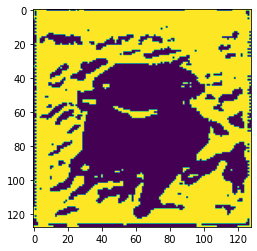

In [196]:
plt.imshow(pred.cpu().detach().numpy())

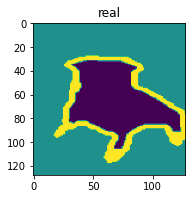

In [184]:

with torch.no_grad():

  plt.subplot(1, 2, 2)
  plt.title('real')
  plt.imshow(label.squeeze())
  plt.show()